# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

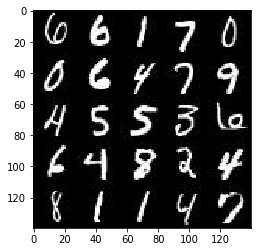

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

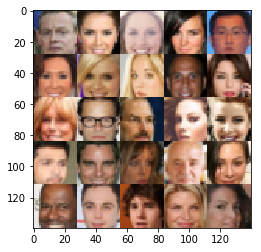

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (real_input, z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 4, strides=1, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 4, strides=1, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 4, strides=1, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 6*6*512)
        h1 = tf.reshape(h1, (-1, 6, 6, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same', activation=None)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=2, padding='same', activation=None)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)

        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=1, padding='valid')
       
        out = tf.tanh(logits)
   
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real)*0.9)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

        return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    images_count, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                # At the end of each epoch, get the losses and print them out
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                if steps % 5 == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    # Show each 25th Generator Output
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5485... Generator Loss: 3.2667
Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 4.6955
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 3.6580
Epoch 1/2... Discriminator Loss: 0.3875... Generator Loss: 4.1631
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 5.2150
Epoch 1/2... Discriminator Loss: 0.4004... Generator Loss: 3.3857
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.1163
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 6.0123
Epoch 1/2... Discriminator Loss: 0.4698... Generator Loss: 4.1846
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 3.6062
Epoch 1/2... Discriminator Loss: 0.5442... Generator Loss: 6.0756
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 1.0239
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 2.0854
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 1.4816
Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 2.0742
Epoch 1/2.

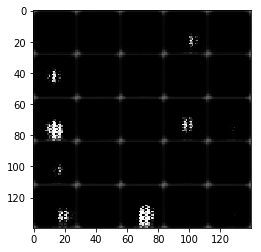

Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 1.6238
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 0.6117... Generator Loss: 2.0644
Epoch 1/2... Discriminator Loss: 0.7951... Generator Loss: 1.7756
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 1.9697
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 1.7348
Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 1.9497
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.5822
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.7310
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 1.8420
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.9490
Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 1.9644
Epoch 1/2... Discriminator Loss: 0.5696... Generator Loss: 2.4912
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.3957
Epoch 1/2.

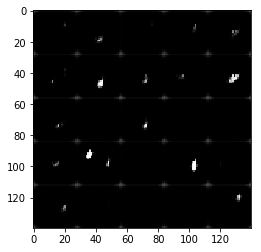

Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 1.6723
Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 0.5422
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 1.2127
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 1.1399
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.6714
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.3909
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.1017
Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 1.1769
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 1.2883
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 1.8883
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 1.5043
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.2281
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 1.6874
Epoch 1/2.

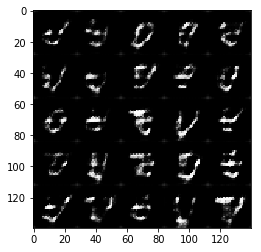

Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.6473
Epoch 1/2... Discriminator Loss: 1.0560... Generator Loss: 1.2324
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.6290
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 1.0945
Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 1.1313
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.5703
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.7659
Epoch 1/2.

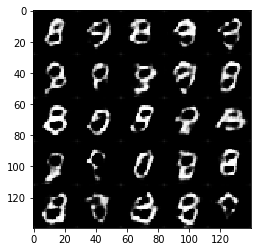

Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 1.3870
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 1.2459
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 1.0467
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.7505
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.9696
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 1.1578
Epoch 1/2... Discriminator Loss: 1.2241... Generator Loss: 0.9497
Epoch 1/2.

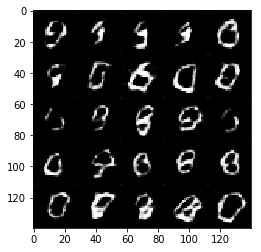

Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 1.0656
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 0.9502
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.9752
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 1.1341
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 1.3694
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 1.1763
Epoch 1/2.

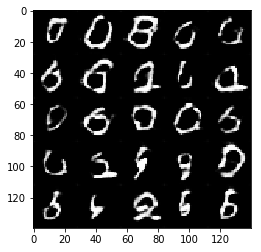

Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.7754
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 1.1716
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.9330
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 0.8984
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.9420
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.6874
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.8102
Epoch 1/2.

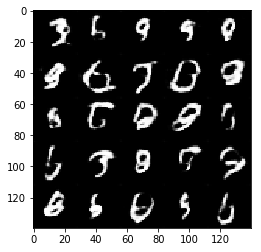

Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 1.1113
Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.6372
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.8866
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.6526
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 1.4343
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.8027
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.6854... Generator Loss: 1.6577
Epoch 1/2.

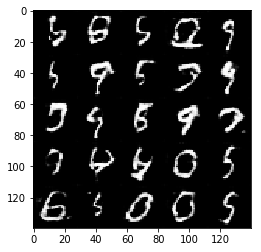

Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.9515
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 1.2419
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.8541
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 1.1523
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.6714
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.5688
Epoch 1/2.

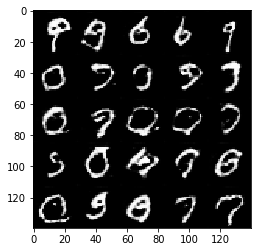

Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.8967
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 1.1782
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 1.0214
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.7838... Generator Loss: 1.8262
Epoch 2/2... Discriminator Loss: 1.2545... Generator Loss: 0.9377
Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 0.9759
Epoch 2/2.

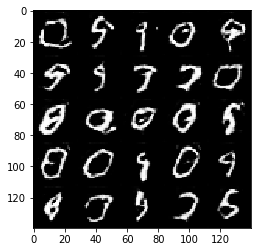

Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.1557... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.8753
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 1.5554
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 1.3035
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.4300... Generator Loss: 0.5481
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 1.3234
Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 0.5739
Epoch 2/2.

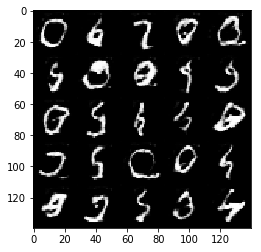

Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 1.0190
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.8511
Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 0.4969
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 1.5547
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 1.1241
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 0.8569
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 1.5493
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 1.3385
Epoch 2/2... Discriminator Loss: 1.6144... Generator Loss: 0.4481
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.1342... Generator Loss: 0.9798
Epoch 2/2.

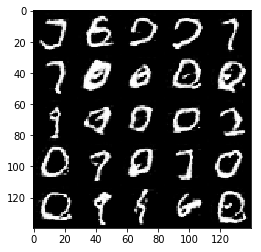

Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 1.1740
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 1.2448
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 1.1731
Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 0.7597
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 1.0287
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 1.1906... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 2.5792... Generator Loss: 2.9901
Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.8896
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.8455
Epoch 2/2.

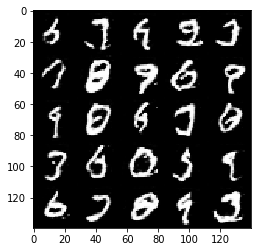

Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 1.7500
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.7131
Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 1.2297... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 1.0941
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 1.0724
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 1.0561... Generator Loss: 1.4249
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 1.1547
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.9039
Epoch 2/2... Discriminator Loss: 1.4606... Generator Loss: 0.6154
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 1.0758
Epoch 2/2.

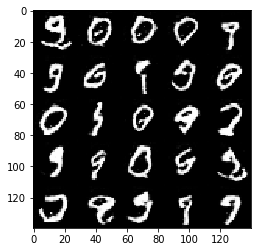

Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 1.0923
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 1.3925
Epoch 2/2... Discriminator Loss: 1.1804... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 1.0443
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.5436
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.9935
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 1.5910
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 1.0209
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 1.6473
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 1.4466
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.6877
Epoch 2/2.

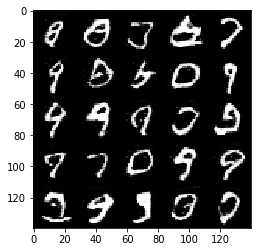

Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 2.2527... Generator Loss: 2.7690
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.9460
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 1.0957
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 1.0448
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.3317
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 1.2133
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 1.1543
Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 1.3204
Epoch 2/2... Discriminator Loss: 1.0441... Generator Loss: 1.3750
Epoch 2/2... Discriminator Loss: 1.7991... Generator Loss: 0.3785
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 1.1230... Generator Loss: 0.9008
Epoch 2/2.

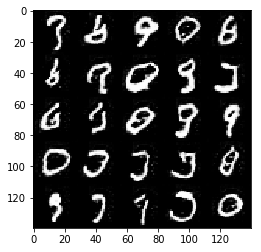

Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.6014
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 1.2581
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 1.2796
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 1.4193
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.0867
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 1.6068
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 1.2996
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.8074
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 1.1717
Epoch 2/2.

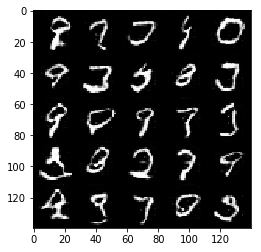

Epoch 2/2... Discriminator Loss: 1.1282... Generator Loss: 0.9155
Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 1.5666
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 0.9177... Generator Loss: 1.2151
Epoch 2/2... Discriminator Loss: 1.6463... Generator Loss: 2.0294
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.0047
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 1.1495
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 1.3227
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 1.5455
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.4645... Generator Loss: 1.7219
Epoch 2/2.

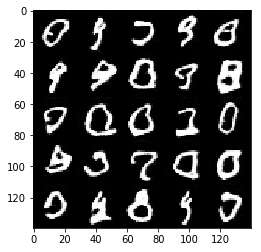

Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 1.1951
Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 1.3164
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 1.1563... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 1.2978... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 1.0471
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.9881
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 1.1601
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 1.6094


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 2.3796
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 5.2468
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 1.8695
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 5.3713
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 4.2529
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 6.0191
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 2.1910
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 3.7171
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 2.9296
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 2.7877
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 2.0886
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.5028
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 2.4830
Epoch 1/1.

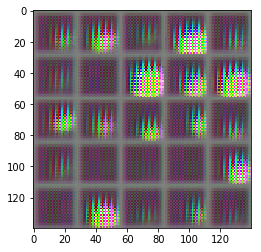

Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 2.4258
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 2.1669
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 3.1235
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.5880
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 2.6211
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 2.7060
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 2.6687
Epoch 1/1... Discriminator Loss: 0.4505... Generator Loss: 3.1977
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 2.8267
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 3.3540
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 3.0832
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.9161
Epoch 1/1... Discriminator Loss: 0.4268... Generator Loss: 3.5397
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 3.5698
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 2.7584
Epoch 1/1.

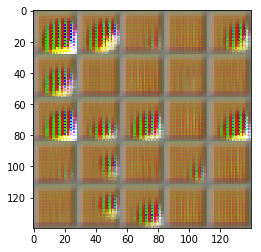

Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 2.3830
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.5131
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 3.0966
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 2.8725
Epoch 1/1... Discriminator Loss: 0.4494... Generator Loss: 2.7351
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 3.4237
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 2.2961
Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 2.4146
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 2.7249
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.0198
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 2.8980
Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 3.0453
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 3.2881
Epoch 1/1... Discriminator Loss: 0.3768... Generator Loss: 3.4925
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 3.0926
Epoch 1/1.

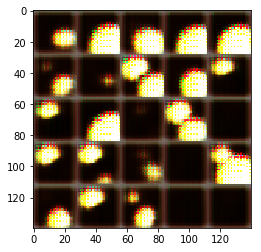

Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 3.3243
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.6054
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 3.3910
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 3.7885
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 2.5844
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.8484
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 3.6897
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 3.8122
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 3.4260
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 2.9984
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.9009
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 3.0340
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 2.1973
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 2.2985
Epoch 1/1.

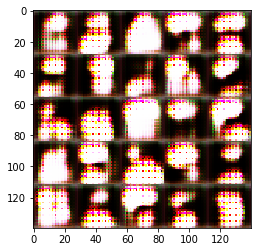

Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 3.1275
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 3.3491
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 2.8350
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.5255
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 3.8076
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 3.1847
Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 3.4769
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.2349
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 3.0369
Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 3.2331
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 3.2427
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 2.8949
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.9086
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 3.5583
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 3.3695
Epoch 1/1.

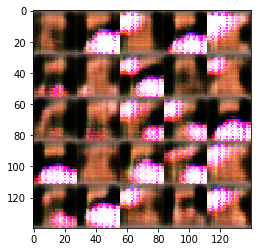

Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.7670
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 2.2531
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 2.4236
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.4314
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.6943
Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 2.2140
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.8733
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.8267
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 1.9758
Epoch 1/1.

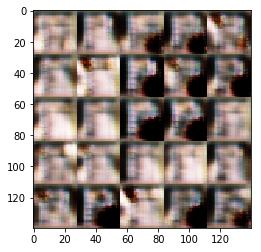

Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.9727
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 3.8078
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 1.9766
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 2.5843
Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.9209
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.6136
Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 2.1664
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 2.3295
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.6670
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 2.0899
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.9250
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 2.0028
Epoch 1/1.

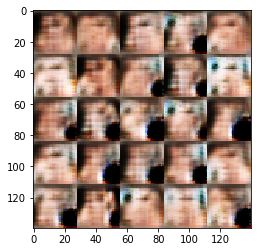

Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.4972
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 2.0451
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 1.9981
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 2.6112
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.4143
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 1.9645
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 2.3227
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.8268
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.3909
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 5.9837
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 3.3795
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.1784
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 3.5449
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 2.6188
Epoch 1/1.

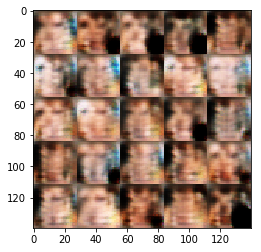

Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 1.9944
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.2791
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.3084
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 2.3452
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.5985
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 2.8326
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 3.6445
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.7670
Epoch 1/1... Discriminator Loss: 1.8037... Generator Loss: 0.3679
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 1.9993
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.2729
Epoch 1/1.

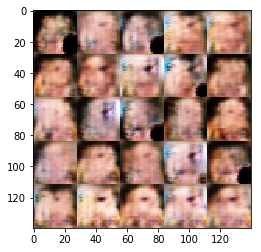

Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 2.3163
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.8938
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.9668
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 2.5351
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.7897
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 2.3250
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 1.6457
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 1.8736
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.9042
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 3.5095
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.8641
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.4400
Epoch 1/1.

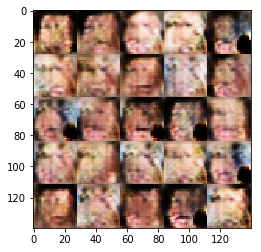

Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 0.5390... Generator Loss: 2.2938
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.6969
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 2.1051
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 2.0405
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 2.3838
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 2.5616
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.8668
Epoch 1/1.

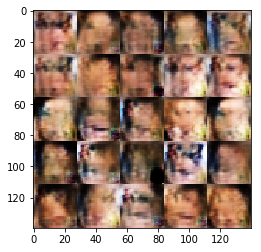

Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 3.8476
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 2.4148
Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 1.4851
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 1.7502
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.6492
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 2.5024
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 2.9787
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 3.5500
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 1.9238
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 3.1267
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.5921
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 2.0809
Epoch 1/1.

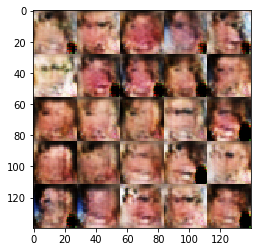

Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 2.1089
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 3.5584
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.7115
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.0723
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 3.1644
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 2.8588
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 2.7617
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.5864
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 3.4552
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 1.8262
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 4.3073
Epoch 1/1.

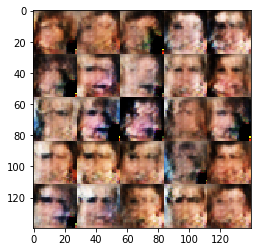

Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.8963
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 2.0848
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 3.0249
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 2.7078
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.8711
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 1.9424
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.6348
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.9581
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.5686
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 2.1213
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 1.8033
Epoch 1/1.

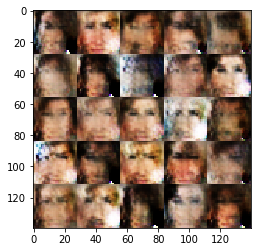

Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 2.0982
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 2.6266
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.6355
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 1.9471
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 2.4625
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 2.0525
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 2.0866
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 2.3654
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 1.8519
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.5885
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.9258
Epoch 1/1.

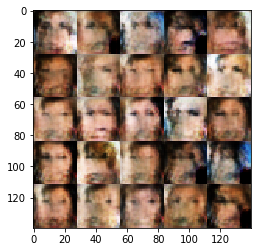

Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.6026
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 2.0464
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 1.5474
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.2682
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 2.3894
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.8523
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 3.0580
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 2.8568
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.9674
Epoch 1/1.

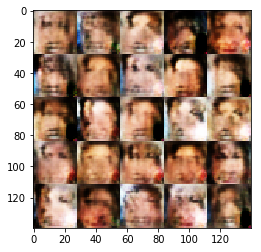

Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 1.8182
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 2.6901
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 2.3832
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 3.0439
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 3.0102
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 3.1900
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.8209
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 2.4977
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.7794
Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 1.9160
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 3.4022
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 3.4149
Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 2.1951
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 3.4181
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 3.4191
Epoch 1/1.

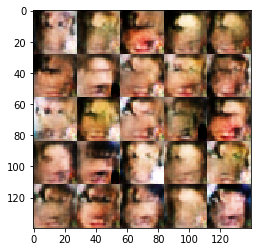

Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 3.6704
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.2579
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 2.3790
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 4.0088
Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 4.0927
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 3.4806
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 3.2575
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 2.5373
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 3.0334
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 5.2301
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 4.8859
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.9601
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 2.8447
Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 3.2790
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8377
Epoch 1/1.

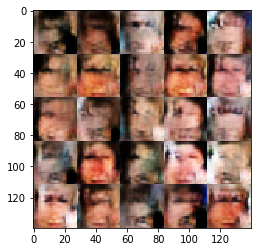

Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.5473
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 4.7162
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.5404
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 3.7191
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 2.5920
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 2.5063
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.9938
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 3.0749
Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 2.4570
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 3.4675
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.6699
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.1563
Epoch 1/1.

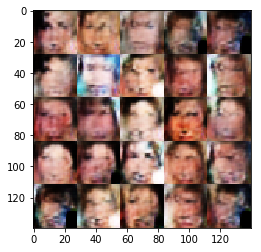

Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 2.9121
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.9074
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 2.7766
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 2.5587... Generator Loss: 1.8469
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.6278
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 2.0346
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.9405
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.9049
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 2.6692
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 2.7132
Epoch 1/1.

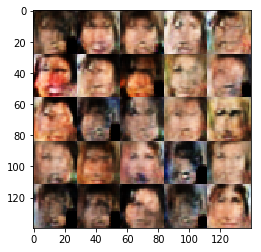

Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 1.9873
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.8458
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.2139
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 1.6501
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 2.1328
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 2.9524
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 2.5171
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.9738
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 4.4441
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 4.2161
Epoch 1/1.

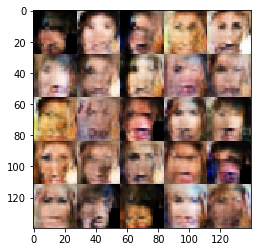

Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.6846
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 2.3339
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.7754
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 2.3695
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 2.7345
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 2.1808
Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 3.1075
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 3.6533
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.4378
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 3.4585
Epoch 1/1.

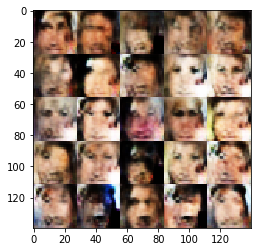

Epoch 1/1... Discriminator Loss: 0.4398... Generator Loss: 3.3585
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 3.4689
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.9749
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 3.4339
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 2.9423
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 3.9515
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 3.8546
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.2686
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 3.7756
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 4.3902
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 4.0858
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 3.7117
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 3.7628
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 3.7156
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 4.4870
Epoch 1/1.

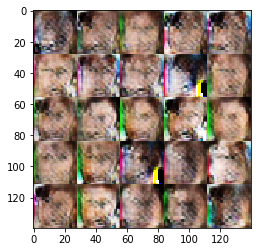

Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 4.3695
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 3.6432
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 4.6120
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 4.9046
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 5.3716
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 4.6001
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 5.0727
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 3.4916
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 4.2849
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 3.6612
Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 4.0804
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 5.4324
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 4.8076
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 4.3317
Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 2.6400
Epoch 1/1.

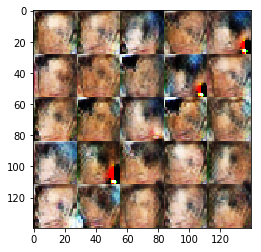

Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 5.3809
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 4.5524
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.6458
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 4.3669
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 4.7970
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 5.8078
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 5.0343
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 3.8690
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 4.7314
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 3.5009
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 3.4222
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.5379
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 7.3281
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 4.2522
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 3.7083
Epoch 1/1.

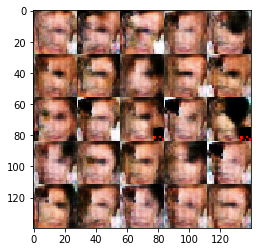

Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 2.7015
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 4.4506
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 2.1729
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 3.5236
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 3.1117
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 4.2740
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 4.3484
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 5.7273
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 3.2974
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 4.6593
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 3.9539
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 3.6820
Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 4.2792
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.2458
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.6576
Epoch 1/1.

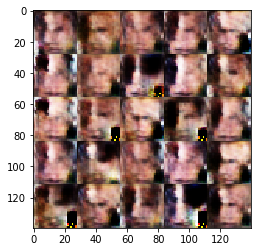

Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 2.9794
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 4.0992
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 3.7159
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.9077
Epoch 1/1... Discriminator Loss: 0.3788... Generator Loss: 3.8744
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 3.3221
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 4.6826
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 4.7816
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 3.5466
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 4.6490
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 2.5774
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.2967
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 6.1292
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 4.7556
Epoch 1/1.

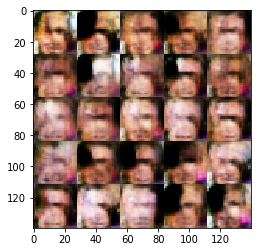

Epoch 1/1... Discriminator Loss: 0.3981... Generator Loss: 5.2802
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 3.6997
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 2.5770
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 3.2096
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 1.5264
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.1672
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 3.3186
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 2.1778... Generator Loss: 4.7482
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 2.6182
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 2.7533
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 2.0333
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 2.1151
Epoch 1/1.

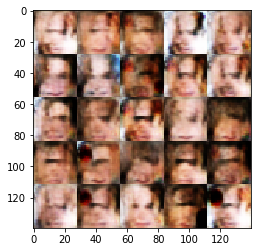

Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 3.1875
Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 2.0469
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 2.6476
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 2.7551
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.2390
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 1.7516
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.7189
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 2.5417
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 2.0403
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.9907
Epoch 1/1.

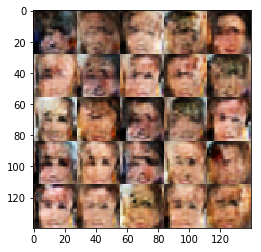

Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.9415
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.7239
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.9309
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.7689
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.9005
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 2.4732
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 2.5238
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.7571
Epoch 1/1.

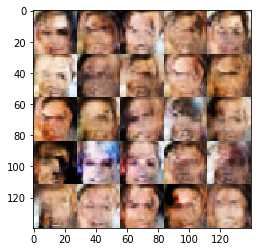

Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.3531
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 2.0556
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 2.0241
Epoch 1/1... Discriminator Loss: 0.4587... Generator Loss: 3.7890
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.8818
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.4904
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.8335
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.7039
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.4372
Epoch 1/1.

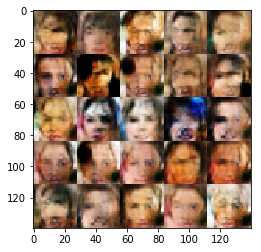

Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.4363
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.1078
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 4.5732
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 2.3516
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 2.0153
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.6222


In [45]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.